In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [3]:
# 2. Đọc file dữ liệu grab và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('/content/drive/MyDrive/GRAB.csv')
df = df[['Close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]


In [4]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.3 MB/s eta 0:00:00


In [5]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=7.773, Time=1.20 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=196.418, Time=0.12 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=127.453, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=3.972, Time=0.41 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=5.937, Time=0.54 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=5.931, Time=0.58 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=7.972, Time=0.47 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=3.903, Time=0.71 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=198.260, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=129.275, Time=0.22 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.92 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0] intercept
Total fit time: 7.287 seconds


ARIMA(order=(0, 2, 1), scoring_args={}, suppress_warnings=True)

In [8]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [9]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted opening prices for the next 30 days
print('Predicted opening prices for the next 30 days:')
print(y_next_30_days)

Predicted opening prices for the next 30 days:
[2.93412723 2.95859881 2.98341481 3.00857524 3.03408009 3.05992937
 3.08612307 3.1126612  3.13954375 3.16677074 3.19434214 3.22225797
 3.25051823 3.27912292 3.30807203 3.33736556 3.36700352 3.39698591
 3.42731272 3.45798396 3.48899963 3.52035972 3.55206423 3.58411317
 3.61650654 3.64924433 3.68232655 3.7157532  3.74952427 3.78363976]


In [10]:
# 7. Tính RMSE, MSE, MAPE
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

valid_mse = mean_squared_error(y_val, y_pred_val)
test_mse = mean_squared_error(y_test, y_pred)

valid_rmse = np.sqrt(valid_mse)
test_rmse = np.sqrt(test_mse)

valid_mae = mean_absolute_error(y_val, y_pred_val)
test_mae = mean_absolute_error(y_test, y_pred)

valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)*100
test_mape = mean_absolute_percentage_error(y_test, y_pred)*100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 0.7598023361690331
Testing RMSE: 1.6822016338205092
Validation MAE: 0.6367446383441379
Testing MAE: 1.3319788239833192
Validation MAPE: 19.947361150498004
Testing MAPE: 37.9036590656771


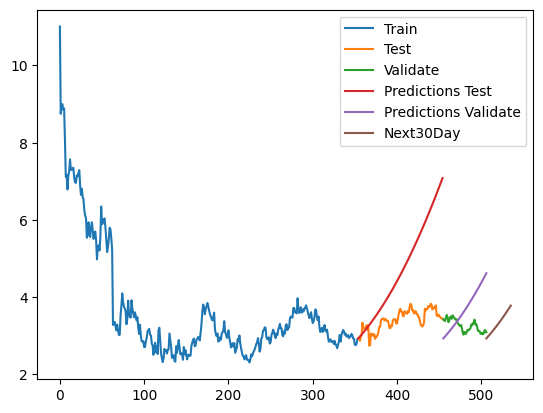

In [12]:
# 8.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Validate', 'Predictions Test', 'Predictions Validate','Next30Day'])
plt.show()

In [14]:
test_data.index

RangeIndex(start=354, stop=455, step=1)